# Unit 1 - Cost of Teacher

Group members:

- Ole Magnus Laerum
- Piotr Franc

## Task description
Use the dataset BostonHousing2 (target value is target_column) with the following train1/train2/test partition. Use the dataset train1 to explore learning methods and techniques in a way that you want to reduce the amount of data used for training without compromising the performance of the model too much. Once the best methodology is selected, use it with train2 to show a plot of performance (RMSE) vs instances employed measured with the test partition. Grow this plot incrementally (i.e, add new instances to the already used instances) Select the instances of train2 without using the class label of the instances already not employed.

In [201]:
### ---- Import libraries ------------------------------------------------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor, BaggingRegressor

from xgboost import XGBRegressor



Train1 size: (202, 13)
Train2 size: (152, 13)
Test size: (152, 13)
------------------------------ RMSE values for 9 models:------------------------------------------------------------
Stacking: RMSE: 2.88 || R²: 0.89
Extra Trees: RMSE: 2.94 || R²: 0.88
Gradient Boosting: RMSE: 3.09 || R²: 0.87
XGBoost: RMSE: 3.20 || R²: 0.86
AdaBoost Regressor: RMSE: 3.40 || R²: 0.84
Random Forest: RMSE: 3.54 || R²: 0.83
Bagging Regressor: RMSE: 4.09 || R²: 0.77
Linear Regression: RMSE: 5.31 || R²: 0.62
Decision Tree: RMSE: 6.06 || R²: 0.50

Best model: Stacking with RMSE: 2.88 and R²: 0.89


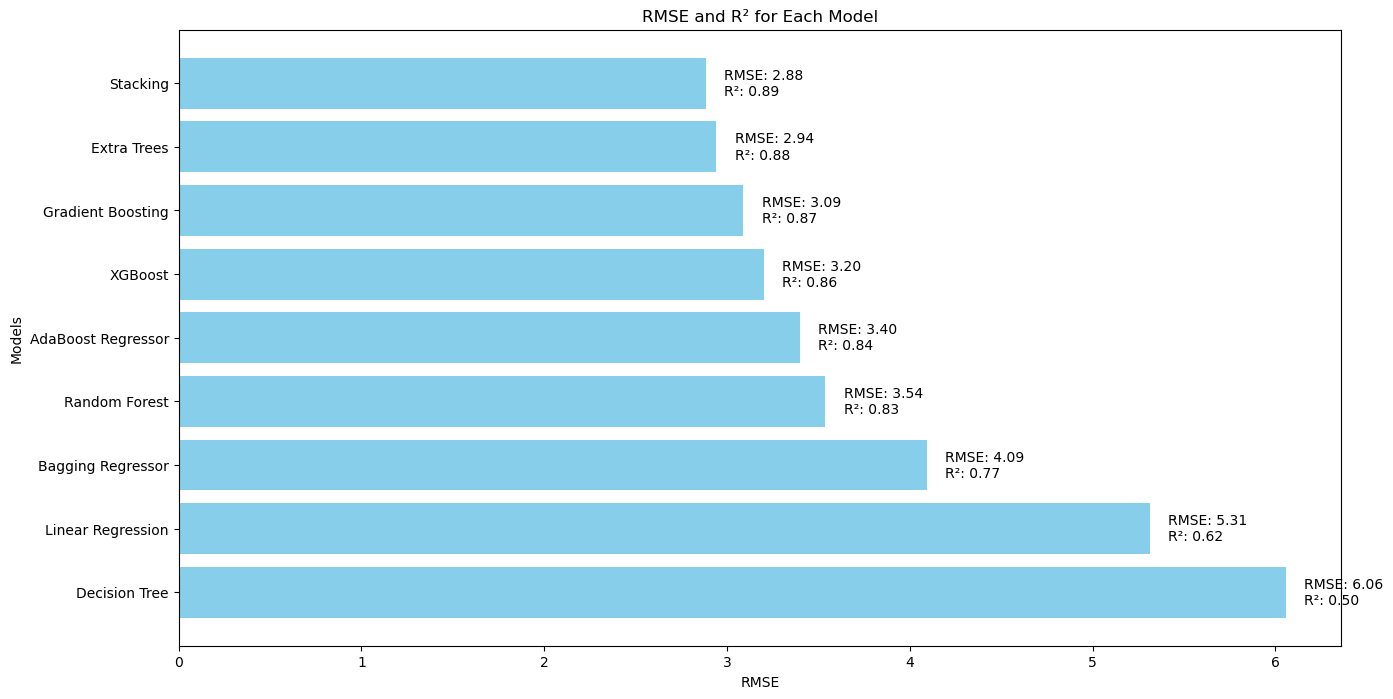


Top 5 models for incremental learning: ['Stacking', 'Extra Trees', 'Gradient Boosting', 'XGBoost', 'AdaBoost Regressor']
Performing incremental learning with Stacking ...
Performing incremental learning with Extra Trees ...
Performing incremental learning with Gradient Boosting ...
Performing incremental learning with XGBoost ...
Performing incremental learning with AdaBoost Regressor ...


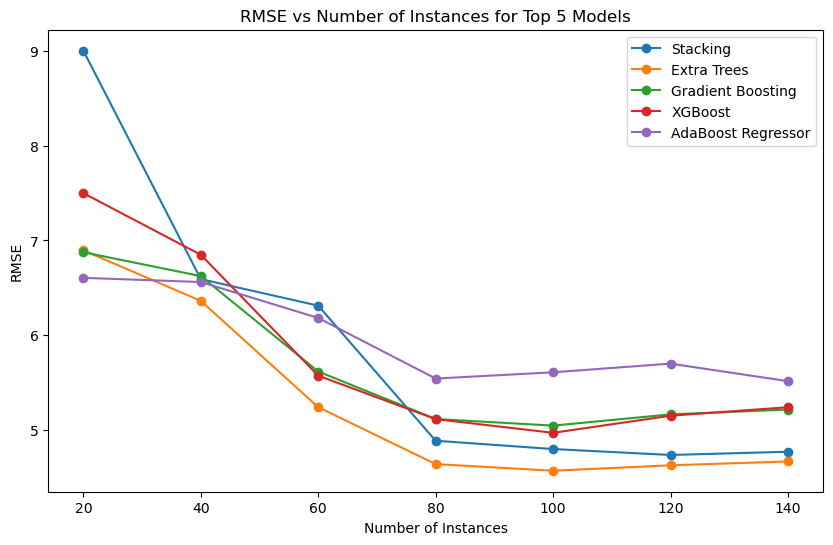

In [202]:
### ---- Import the dataset -------------------------------------------------------------------------------------------------

boston = fetch_openml(data_id=531, as_frame=True, parser='pandas')
data = boston.frame

# Remove column index 4 to match R code
mddata = data.drop(columns=[data.columns[4]])

np.random.seed(280)

train1, temp = train_test_split(mddata, test_size=0.6, random_state=280)
train2, test = train_test_split(temp, test_size=0.5, random_state=280)

print("Train1 size:", train1.shape)
print("Train2 size:", train2.shape)
print("Test size:", test.shape)

### --- Preprocessing the dataset (Fix the datatypes that are categories and not float64) -------------------------------------

train1["CHAS"] = train1["CHAS"].astype(int)
train1["RAD"] = train1["RAD"].astype(int)

train2["CHAS"] = train2["CHAS"].astype(int)
train2["RAD"] = train2["RAD"].astype(int)

test["CHAS"] = test["CHAS"].astype(int)
test["RAD"] = test["RAD"].astype(int)

target_column = "MEDV"

def train_and_evaluate_model(train, test, target_column, model):

    #Train the model
    model.fit(train.drop(columns=[target_column]), train[target_column])

    #Test the model
    preds = model.predict(test.drop(columns=[target_column]))

    # Calculate RMSE and R²
    mse = np.sqrt(mean_squared_error(test[target_column], preds))
    r2 = r2_score(test[target_column], preds)

    return mse, r2

### ---- Models ----------------------------------------------------------------------------------------------------

random_state_nr = 55
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(max_depth=10, random_state=random_state_nr ),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=random_state_nr ),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, max_depth=3),
    "XGBoost": XGBRegressor(n_estimators=50, learning_rate=0.1, max_depth=3),
    "AdaBoost Regressor": AdaBoostRegressor(n_estimators=100, random_state=random_state_nr ),
    "Extra Trees": ExtraTreesRegressor(n_estimators=100, random_state=random_state_nr ),
    "Bagging Regressor": BaggingRegressor(n_estimators=10, random_state=random_state_nr ),
    "Stacking": StackingRegressor(
        estimators=[
            ('rf', RandomForestRegressor(n_estimators=100, random_state=random_state_nr )),
            ('gbr', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)),
            ('etr', ExtraTreesRegressor(n_estimators=100, random_state=random_state_nr )),  
            ('abr', AdaBoostRegressor(n_estimators=100, random_state=random_state_nr ))   
        ],
        final_estimator=Ridge()
    ),
}


### ---- Train and Evaluate ----------------------------------------------------------------------------------------------------

print("-"*30 + f" RMSE values for {len(models)} models:" + "-" * 60)

results = {}
for name, model in models.items():
    rmse, r2 = train_and_evaluate_model(train1, test, target_column, model)
    results[name] = {"RMSE": rmse, "R2": r2}

#Sort the results by RMSE
sorted_results = sorted(results.items(), key=lambda x: x[1]["RMSE"])

for name, metrics in sorted_results:
    print(f"{name}: RMSE: {metrics['RMSE']:.2f} || R²: {metrics['R2']:.2f}")

# Get the best model
best_model_name = sorted_results[0][0]
best_model = models[best_model_name]

print(f"\nBest model: {best_model_name} with RMSE: {results[best_model_name]['RMSE']:.2f} and R²: {results[best_model_name]['R2']:.2f}")

### ---- Plotting part 1 ----------------------------------------------------------------------------------------------------

model_names = [name for name, _ in sorted_results]
rmse_values = [metrics["RMSE"] for _, metrics in sorted_results]
r2_values = [metrics["R2"] for _, metrics in sorted_results]

plt.figure(figsize=(15, 8))
bars = plt.barh(model_names, rmse_values, color='skyblue')

# Add numerical annotations for RMSE and R²
for bar, rmse, r2 in zip(bars, rmse_values, r2_values):
    plt.text(
        bar.get_width() + 0.1, 
        bar.get_y() + bar.get_height() / 2, 
        f"RMSE: {rmse:.2f}\nR²: {r2:.2f}",  
        va='center', 
        fontsize=10,  
        color='black' 
    )

plt.xlabel("RMSE")
plt.ylabel("Models")
plt.title("RMSE and R² for Each Model")
plt.gca().invert_yaxis()
plt.show()

### ---- Incremental Learning ----------------------------------------------------------------------------------------------------

# Get the top models based on RMSE
amount_of_top_models = 5
top_models = sorted_results[:amount_of_top_models]  
top_model_names = [model[0] for model in top_models]

incremental_results = {name: {"rmse_values": [], "num_instances": []} for name in top_model_names}

#Randomly shuffle the training set for simulate unlabeled data
train2 = train2.sample(frac=1, random_state=random_state_nr).reset_index(drop=True)

print(f"\nTop {amount_of_top_models} models for incremental learning: {top_model_names}")
for model_name in top_model_names:
    print(f"Performing incremental learning with {model_name} ...")
    model = models[model_name]  

    rmse_values = []
    num_instances = []

    for size in range(20, len(train2), 20):
        partial_train2 = train2.iloc[:size]

        rmse, _ = train_and_evaluate_model(partial_train2, test, target_column, model)

        rmse_values.append(rmse)
        num_instances.append(len(partial_train2))

    #Save the final results
    incremental_results[model_name]["rmse_values"] = rmse_values
    incremental_results[model_name]["num_instances"] = num_instances

### ---- Plotting part 2 ----------------------------------------------------------------------------------------------------

plt.figure(figsize=(10, 6))
for model_name in top_model_names:
    plt.plot(
        incremental_results[model_name]["num_instances"],
        incremental_results[model_name]["rmse_values"],
        marker="o",
        linestyle="-",
        label=model_name,
    )

plt.xlabel("Number of Instances")
plt.ylabel("RMSE")
plt.title(f"RMSE vs Number of Instances for Top {amount_of_top_models} Models")
plt.legend()
plt.show()